# Get HP and LP case scenarios

See bottom part of the `README.md` for motivation. We want to get the HP and LP data points, **as determined by the PCA metric only**, to selectively train ML models. In other commits, at first, I used "best" and "worst" to describe this process, but those are not the best terms to be using for this so instead I changed it to HP and LP.  We hypothesize that HP and LP correspond to "data that are most likely to expand the horizons of an ML model" and "data that are most likely to reinforce the existing understanding of the ML model", respectively.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
avg_df = pd.read_csv('post_01_output_ml_predict_avg.csv-Nov-2023-log10-DO-update-correct')
std_df = pd.read_csv('post_01_output_ml_predict_std.csv-Nov-2023-log10-DO-update-correct')

# Use Sample_ID as the index so files can be merged on this value
avg_df.set_index('Sample_ID',inplace=True)
std_df.set_index('Sample_ID',inplace=True)

# We want to get only the SSS, S19S, and CM_ sites. But for now, it's easier to just merge
# everything and compute everything.
all_df = pd.merge(
        avg_df,
        std_df, 
        left_index=True,
        right_index=True,
        suffixes=['_avg','_std'])

# Compute the metric combining the average PCA distance and the ensemble spread uncertainty as an error estimate.
# The "HP" sites are those with high PCA distance and high uncertainty.
# The "LP" sites are those with low PCA distance and low uncertainty.
all_df['ensemble_spread_metric'] = (all_df['pca.dist_avg']/all_df['pca.dist_avg'].max()) * (all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std']/all_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std'].max())

In [3]:
# Display some values to cross check
all_df

,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,ensemble_spread_metric
Sample_ID,,,,,,,,,,,,,,,,,,,
100001,-67.927361,47.160181,-203.193094,74.335300,934.617882,1.250399,0.173833,0.088274,0.015345,0.0,0.0,241.124361,17.760051,210.369212,0.0,0.055002,0.0,0.004855,0.007929
100002,-68.002459,46.847909,-338.189003,82.809223,935.696389,1.678210,0.191350,0.118476,0.022670,0.0,0.0,470.403527,39.815757,211.573619,0.0,0.085986,0.0,0.010187,0.020761
100003,-67.831939,46.773619,-325.986061,83.260482,935.767619,1.819086,0.191842,0.128421,0.024636,0.0,0.0,483.035175,41.090945,211.664164,0.0,0.087287,0.0,0.011210,0.023108
100004,-67.298037,45.168718,-130.951314,73.819376,934.576007,1.081908,0.173068,0.076379,0.013219,0.0,0.0,36.330123,17.293418,210.335180,0.0,0.055464,0.0,0.004236,0.001034
100005,-67.935542,44.606084,-65.588434,75.522781,934.712317,0.564578,0.177505,0.039857,0.007075,0.0,0.0,27.570025,17.301685,210.334771,0.0,0.057805,0.0,0.002304,0.000409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SSS047-2,-120.921300,47.185700,-151.828457,73.257573,934.531438,2.254710,0.171683,0.159174,0.027328,0.0,0.0,29.049602,17.190176,210.328502,0.0,0.055093,0.0,0.008769,0.001723
SSS047-3,-120.921300,47.185700,-147.186330,73.350642,934.538639,2.254710,0.171745,0.159174,0.027337,0.0,0.0,38.649508,17.290526,210.337219,0.0,0.054397,0.0,0.008659,0.002292
SSS048-1,-120.733400,47.082200,-133.955661,73.807215,934.575403,1.570805,0.172623,0.110893,0.019143,0.0,0.0,59.034807,17.542923,210.354082,0.0,0.054099,0.0,0.005999,0.002439


In [4]:
# Now, get only the data points that correspond to S19S, SSS, and CM_ -> the actual sites we can use for training.
# First reset the index to something other than Sample_ID:
all_df.reset_index(inplace=True)
search_str="S19S|SSS|CM_"
obs_df=all_df[all_df['Sample_ID'].str.contains(search_str)]

In [5]:
# Cross check selection
obs_df.describe()

,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,ensemble_spread_metric
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.0,684.0,684.000000,684.000000,684.000000,684.0,684.000000,684.0,684.000000,684.000000
mean,-101.230300,40.594346,-374.403048,89.066077,937.159367,2.825715,0.207281,0.199485,0.042451,0.0,0.0,155.403504,23.991624,210.829030,0.0,0.068144,0.0,0.014235,0.012984
std,19.256967,6.486410,737.378373,45.015744,8.519407,1.659103,0.101939,0.117127,0.037231,0.0,0.0,273.299248,19.546940,2.146849,0.0,0.037390,0.0,0.014365,0.029495
min,-149.597200,25.409760,-3820.783779,71.247999,934.375374,0.048791,0.167308,0.003444,0.000611,0.0,0.0,17.173283,14.292076,207.953125,0.0,0.049653,0.0,0.000195,0.000033
25%,-120.649600,35.755594,-204.077692,73.989973,934.590224,1.537300,0.173392,0.108528,0.019519,0.0,0.0,27.690887,17.314536,210.334533,0.0,0.055199,0.0,0.006193,0.001533
50%,-105.501086,40.989942,-102.812162,75.309833,934.696888,2.674500,0.176571,0.188810,0.035296,0.0,0.0,39.366221,17.528736,210.353810,0.0,0.056576,0.0,0.011363,0.003725
75%,-83.157759,46.205900,-64.969567,75.978385,934.749452,3.960912,0.178196,0.279626,0.051462,0.0,0.0,129.133544,17.673495,210.364097,0.0,0.057510,0.0,0.016296,0.007960
max,-68.445497,68.669670,-40.434105,326.181620,990.122110,8.214588,0.738853,0.579920,0.281642,0.0,0.0,2113.073127,172.686598,237.295846,0.0,0.280808,0.0,0.116364,0.263767


In [6]:
# Sort the list - THIS IS WHERE THE MAIN MODIFICATION IS WRT get_hp_and_lp_sites.ipynb!
obs_df.sort_values(inplace=True, axis='index', ascending=True, by='pca.dist_avg')

/tmp/ipykernel_4837/1070099996.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df.sort_values(inplace=True, axis='index', ascending=True, by='pca.dist_avg')


In [7]:
# Cross check
obs_df

,Sample_ID,Sample_Longitude_avg,Sample_Latitude_avg,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg,mean.error_avg,predict.error_avg,pca.dist_avg,mean.error.scaled_avg,pca.dist.scaled_avg,combined.metric_avg,Sample_Longitude_std,Sample_Latitude_std,Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_std,mean.error_std,predict.error_std,pca.dist_std,mean.error.scaled_std,pca.dist.scaled_std,combined.metric_std,ensemble_spread_metric
10732,CM_108-3,-78.635410,37.414590,-62.582299,75.606639,934.718845,0.048791,0.177319,0.003444,0.000611,0.0,0.0,25.365083,17.503985,210.352750,0.0,0.056720,0.0,0.000195,0.000033
10730,CM_108-1,-78.635410,37.414590,-62.946517,75.599489,934.718279,0.048791,0.177304,0.003444,0.000611,0.0,0.0,25.852478,17.495433,210.351977,0.0,0.056700,0.0,0.000195,0.000033
10731,CM_108-2,-78.635410,37.414590,-62.665715,75.612023,934.719292,0.048791,0.177326,0.003444,0.000611,0.0,0.0,26.630356,17.500899,210.352437,0.0,0.056662,0.0,0.000195,0.000034
10710,CM_101-2,-80.956912,33.995963,-63.505765,75.569202,934.716005,0.157308,0.177176,0.011105,0.001968,0.0,0.0,27.156842,17.685388,210.366997,0.0,0.056823,0.0,0.000631,0.000112
10709,CM_101-1,-80.956912,33.995963,-64.066804,75.549566,934.714379,0.157308,0.177132,0.011105,0.001967,0.0,0.0,26.678493,17.674237,210.366253,0.0,0.056811,0.0,0.000631,0.000110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10837,S19S_0032-U,-119.023750,36.954970,-71.033043,75.397686,934.702542,8.196440,0.176785,0.578639,0.102295,0.0,0.0,33.987159,17.791343,210.374015,0.0,0.057596,0.0,0.033327,0.007326
10836,S19S_0032-M,-119.023670,36.955030,-63.972505,75.544809,934.714400,8.196440,0.177241,0.578639,0.102558,0.0,0.0,34.283219,17.615333,210.359311,0.0,0.057518,0.0,0.033282,0.007390
10765,S19S_0008-D,-119.027785,36.961112,-57.144834,75.716346,934.728042,8.214588,0.177689,0.579920,0.103045,0.0,0.0,40.007237,17.508835,210.351589,0.0,0.057632,0.0,0.033422,0.008643
10766,S19S_0008-M,-119.028281,36.961369,-164.570046,77.240868,934.874696,8.214588,0.183200,0.579920,0.106241,0.0,0.0,310.754255,15.805381,210.108278,0.0,0.061398,0.0,0.035606,0.067133


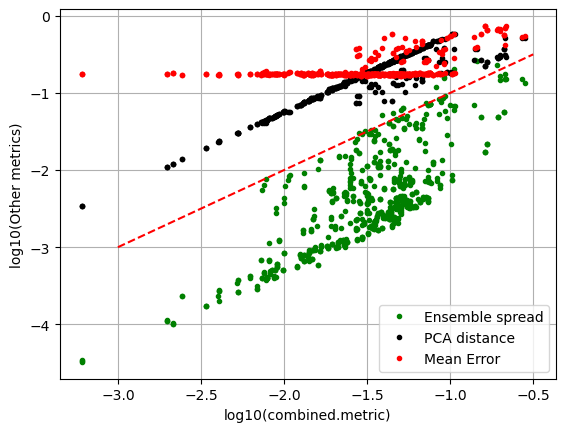

In [27]:
# Out of curiousity, how does the older "combined.metric" compare to the PCA metric used here?
fig, ax = plt.subplots(1,1)

#ax.plot(obs_df['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg'],obs_df['mean.error_avg'],'k.')

ax.plot(np.log10(obs_df['combined.metric_avg']),np.log10(obs_df['ensemble_spread_metric']),'g.')
ax.plot(np.log10(obs_df['combined.metric_avg']),np.log10(obs_df['pca.dist.scaled_avg']),'k.')
ax.plot(np.log10(obs_df['combined.metric_avg']),np.log10(obs_df['mean.error.scaled_avg']),'r.')

# Just a quick peek at these two
#ax.plot(np.log10(obs_df['ensemble_spread_metric']),np.log10(obs_df['pca.dist.scaled_avg']),'b.')

ax.plot((-3.0, -0.5), (-3.0, -0.5), 'r--')
ax.grid()
plt.xlabel('log10(combined.metric)')
plt.ylabel('log10(Other metrics)')
ax.legend(['Ensemble spread','PCA distance','Mean Error'])

Looks like there is a reasonable relationship between `Ensemble spread`, `PCA distance` and `Combined metric`, so I don't expect the results to change that much if we pick the 100|200|300 HP and LP based on the ensemble spread metric, the standard combined metric, or the PCA distance metric. Interestingly, there is very little relationship between the `Mean error` and the other metrics. This is because the mean error is very tightly coupled to the predicted respiration rate while the others are less tied.

Save the sorted data frame here (all points) so it can be sliced and diced as needed. For example, to grab the 100 lp and hp points, use `head` and `tail` (and need to account for the header line!):
```
head -101 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > lp_100.csv
head -1 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > hp_100.csv
tail -100 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv >> hp_100.csv
```

In [28]:
# Reset the index to Sample_ID so that this is the first column
# in the csv file when it is written. When 100|200|300 subsets
# are taken, it is only the first column that is read by
# make_input_data.py
obs_df.set_index('Sample_ID',inplace=True)

In [29]:
# Overwrite any existing file
# There are 685 lines (684 data points + 1 header) => 300 HP, 300 LP, 84 neutal
obs_df.to_csv('hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv', mode='w')

In [67]:
# Get LP 100 file
! head -101 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > lp_100.csv

# Get HP 100 file (header separate)
! head -1 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > hp_100.csv
! tail -100 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv >> hp_100.csv

# Get LP 200 file
! head -201 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > lp_200.csv

# Get LP 300 file
! head -301 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > lp_300.csv

# Get HP 200 file
! head -1 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > hp_200.csv
! tail -200 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv >> hp_200.csv

# Get HP 300 file
! head -1 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > hp_300.csv
! tail -300 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv >> hp_300.csv

# Get neutral file - use 385 instead of 384 to account for the header.
! head -1 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv > mp_084.csv
! head -385 hp_and_lp_sites_Nov-2023-log10-DO-update-correct.csv | tail -84 >> mp_084.csv

## Cross check the HP and LP input files with a plot

For: lp_300.csv
2.348236478227806
0.0487907546645696
For: lp_200.csv
1.6909033635390731
0.0487907546645696
For: lp_100.csv
1.0515024501468324
0.0487907546645696
For: hp_300.csv
8.214588337477513
2.927109550078247
For: hp_200.csv
8.214588337477513
3.775203894407652
For: hp_100.csv
8.214588337477513
4.575526358927654
For: mp_084.csv
2.927109550078247
2.3889249571173505


Text(0, 0.5, 'Count of elements')

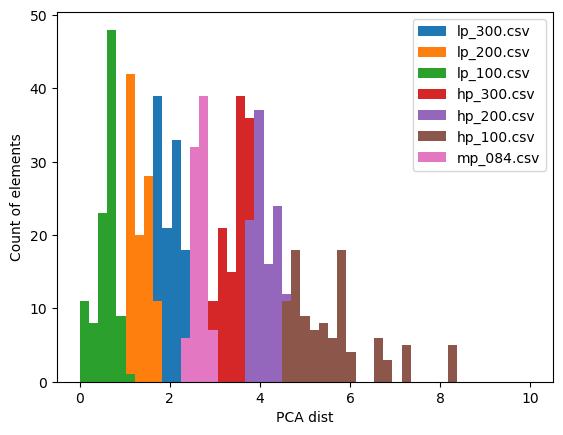

In [68]:
fig, ax = plt.subplots()

df_list = [    
    "lp_300.csv",
    "lp_200.csv",
    "lp_100.csv",
    "hp_300.csv",
    "hp_200.csv",
    "hp_100.csv",
    "mp_084.csv"]

#bins = [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30,0.31,0.32,0.33,0.35,0.36,0.37,0.38,0.39,0.40]
bins = np.linspace(0.0,10,50)
for df in df_list:
    var="pca.dist_avg"
    my_df = pd.read_csv('./hp_lp_training_data_based_on_pca_dist/'+df)
    print("For: "+df)
    print(my_df[var].max())
    print(my_df[var].min())
    
    ax.hist(my_df[var], bins=bins, histtype='stepfilled')

ax.legend(df_list)
ax.set_xlabel('PCA dist')
ax.set_ylabel('Count of elements')

## Additional plots: we want to see the distributions of respiration rates and combined metric

These distributions will help assess the biases in the trainig and test data to provide context for the model scores. This section is run independently from the above cells. When the cells above ran, the `hp_*`, `lp_*`, and `mp_*` files were in this directory. Since then, I moved those files into `hp_lp_training_data_based_on_combined_metric` (for HP and LP sites ranked by `combined.metric` as in the original ICON-ModEx iterations) and `hp_lp_training_data_based_on_ensemble_spread`. The ensemble spread approach was exploratory and is depreciated.

For lp_300.csv percent hot: 13.0
For lp_200.csv percent hot: 8.0
For lp_100.csv percent hot: 4.0
For hp_300.csv percent hot: 15.0
For hp_200.csv percent hot: 16.0
For hp_100.csv percent hot: 15.0
For mp_084.csv percent hot: 11.0


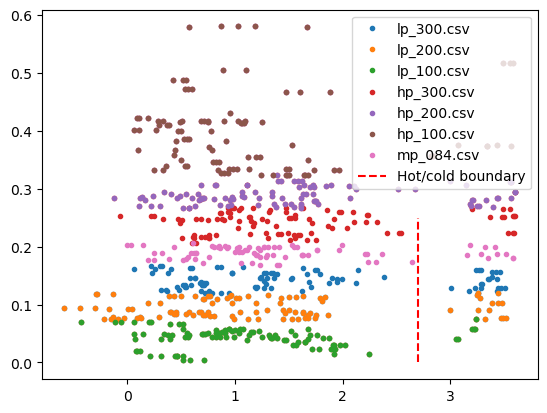

In [69]:
fig, ax = plt.subplots()

df_list = [    
    "lp_300.csv",
    "lp_200.csv",
    "lp_100.csv",
    "hp_300.csv",
    "hp_200.csv",
    "hp_100.csv",
    "mp_084.csv"]

for df in df_list:
    df_combined_metric = pd.read_csv('./hp_lp_training_data_based_on_pca_dist/'+df)
    df_respiration_rate = pd.read_csv('./hp_lp_training_data_based_on_pca_dist/'+df+".out")
    
    # Must merge-sort the two data sets since they are out of order
    df_combined_metric.set_index('Sample_ID', inplace=True)
    df_respiration_rate.set_index('Sample_ID', inplace=True)
    merged = pd.merge(
        df_combined_metric, 
        df_respiration_rate,
        left_index=True, right_index=True, suffixes=['_1','_2'])
    
    ax.plot(
        np.log10(np.abs(merged['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment'])),
        merged['pca.dist.scaled_avg'],'.'
    )
    
    hot_cutoff = -500.0
    
    # Find percentage of hotspots in each data set:
    n_all = np.shape(merged)[0]
    n_hot = np.shape(merged[merged['Normalized_Respiration_Rate_mg_DO_per_H_per_L_sediment_avg'] < hot_cutoff])[0]
    p_hot = np.round(100*n_hot/n_all)
    
    print('For '+df+' percent hot: '+str(p_hot))
    
ax.plot(
[np.log10(np.abs(hot_cutoff)), np.log10(np.abs(hot_cutoff))],
[0.0,0.25], 'r--')
    
df_list.append('Hot/cold boundary')

ax.legend(df_list)

#plt.xlim([-1,6])

## A note on selecting the hot/cold cut off

Here, it appears by eye that -500 mg O2/L/hr is better than -200 mg O2/L/hr because of the tail of the distribution of the cold spots.
If we shift to the weaker (-200) cutoff, then the LP data sets have about 10% hot spot whereas for the stronger cutoff (-500) the percent of hot spots is substantially lower (less than 5%).